In [1]:
# Imports
from urllib.request import urlopen

from metpy.io.gini import GiniFile
from siphon.catalog import TDSCatalog

# Grab the catalog and then the dataset for the most recent file
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/satellite/IR/WEST-CONUS_4km/current/catalog.xml')
dataset_name = sorted(cat.datasets.keys())[-1]
dataset = cat.datasets[dataset_name]

# Open the GINI file using MetPy and grab as a NetCDF-like Dataset object
remote_gini_file = urlopen(dataset.access_urls['HTTPServer'])
gini = GiniFile(remote_gini_file)
gini_ds = gini.to_dataset()

In [2]:
data_var = gini_ds.variables['IR']
print(data_var)

<class 'metpy.io.cdm.Variable'>: uint8 IR(y, x)
	long_name: IR (11 micron)
	missing_value: 255
	coordinates: y x
	grid_mapping: Lambert_Conformal
	shape = (1280, 1100)


In [3]:
x = gini_ds.variables['x'][:]
y = gini_ds.variables['y'][:]

In [4]:
proj_var = gini_ds.variables[data_var.grid_mapping]

In [5]:
print(proj_var)

<class 'metpy.io.cdm.Variable'>: int32 Lambert_Conformal()
	grid_mapping_name: lambert_conformal_conic
	standard_parallel: 25.0
	longitude_of_central_meridian: -95.0
	latitude_of_projection_origin: 25.0
	earth_radius: 6371200.0


In [6]:
import cartopy.crs as ccrs

# Create a Globe specifying a spherical earth with the correct radius
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.earth_radius,
                   semiminor_axis=proj_var.earth_radius)

In [7]:
proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                             central_latitude=proj_var.latitude_of_projection_origin,
                             standard_parallels=[proj_var.standard_parallel],
                             globe=globe)

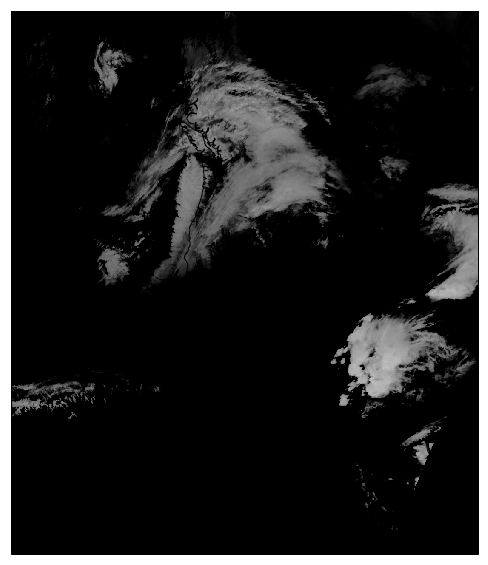

In [8]:
# Make sure the notebook puts figures inline
%matplotlib inline
import matplotlib.pyplot as plt

# Create a new figure with size 10" by 10"
fig = plt.figure(figsize=(10, 10))

# Put a single axes on this figure; set the projection for the axes to be our
# Lambert conformal projection
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the data using a simple greyscale colormap (with black for low values);
# set the colormap to extend over a range of values from 140 to 255.
# Note, we save the image returned by imshow for later...
im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
               cmap='Greys_r', norm=plt.Normalize(140, 255))

# Add high-resolution coastlines to the plot
ax.coastlines(resolution='50m', color='black')

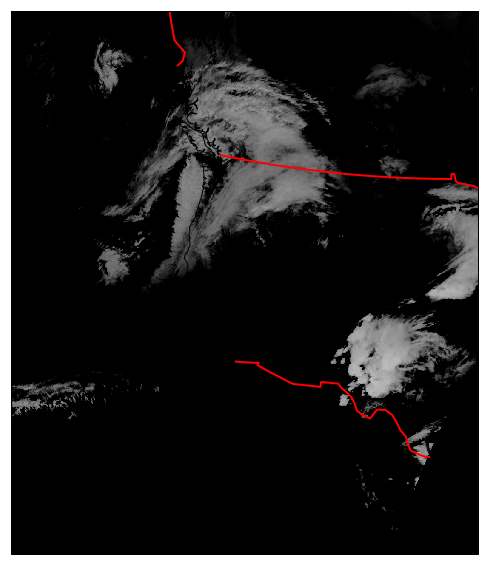

In [9]:
import cartopy.feature as cfeat

# Add country borders with a thick line.
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='red')

# Set up a feature for the state/province lines. Tell cartopy not to fill in the polygons
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lines',
                                             scale='50m', facecolor='none')

# Add the feature with dotted lines, denoted by ':'
ax.add_feature(state_boundaries, linestyle=':')

# Redisplay modified figure
fig

In [10]:
from metpy.plots.ctables import registry
wv_norm, wv_cmap = registry.get_with_steps('WVCIMSS', 0, 1)

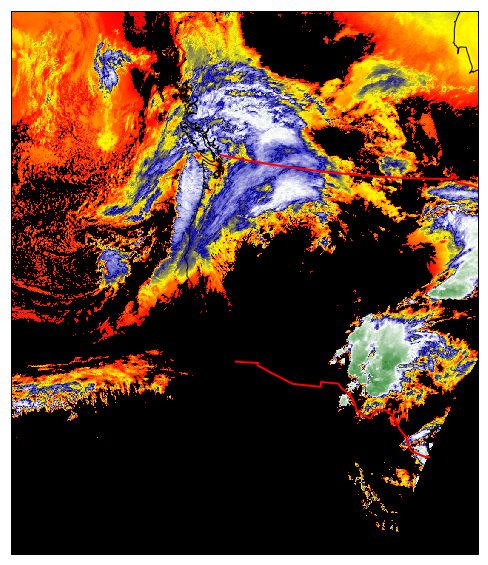

In [11]:
im.set_cmap(wv_cmap)
im.set_norm(wv_norm)
fig

In [12]:
time_var = gini_ds.variables['time']
print(time_var)

<class 'metpy.io.cdm.Variable'>: int32 time(time)
	units: milliseconds since 2017-04-12T00:00:00
	shape = 1


In [13]:
from netCDF4 import num2date
timestamp = num2date(time_var[:].squeeze(), time_var.units)
timestamp

datetime.datetime(2017, 4, 12, 20, 30, 18)

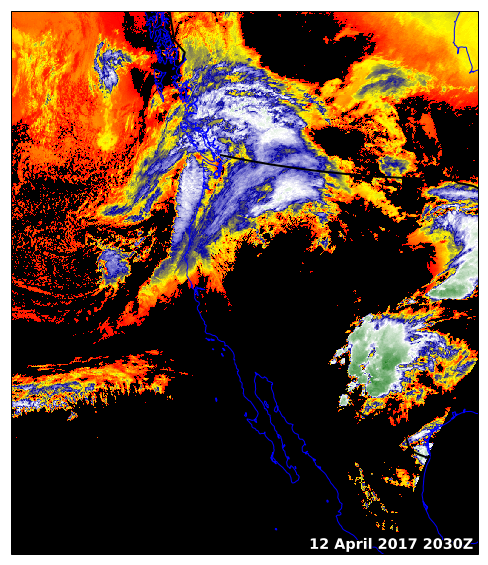

In [14]:
# Same as before, except we call imshow with our colormap and norm.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
               cmap=wv_cmap, norm=wv_norm)
ax.coastlines(resolution='50m', color='blue')
ax.add_feature(state_boundaries, linestyle=':')
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Add text (aligned to the right); save the returned object so we can manipulate it.
text = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')

# Make the text stand out even better using matplotlib's path effects
from matplotlib import patheffects
text.set_path_effects([patheffects.Stroke(linewidth=2, foreground='black'),
                       patheffects.Normal()])